In [1]:
import torch
import math

from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial

import matplotlib.pyplot as plt

import os
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

In [239]:
def solve_sde_RK(b_drift=None, sigma=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(b_drift=None, sigma=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        b_drift  : Time dependan drift, the X state (with last dimension as time)
                defines the differential equation. 
        sigma  : a  constant volatility
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
       
    if b_drift is None or sigma is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    N= N + 1
    T = torch.tensor(dt * N) 
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1) * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double(), torch.arange(N).double() * dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double()
    )

    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n+1]
#         print(t, n)
        b, DW_n = b_drift(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + b * dt + sigma * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
#         print(tocat[0,0,1])
        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()

    return ti, Y

In [240]:
def plot_trajectories_2( Xts, t, remove_time=True, fig_axs=None, color='b', show=True, direction="Forward"):
    """
    Helper function that plots multple trajctories
    """
     
    fn = 14
    if fig_axs is None:
        fig, axs = plt.subplots(1,1,  sharey=False, figsize=(15,10))
        axs.set_ylabel("$x(t)$", fontsize=fn)
    else:
        fig, axs = fig_axs

    n, _, _, = Xts.shape
    
    if remove_time:
        Xts = Xts[...,:-1]

    for i in range(n):
        label = "$\mathbb{Q}$:" + f"{direction} process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i,:,:].detach().cpu().numpy().flatten(), color, alpha=0.3,  label=label)

#     plt.show()
    return (fig, axs)

In [241]:
def setup_gp(X, y,  noise=.1, dt=1, kernel=gp.kernels.Matern32(input_dim=2)):
#     kernel=gp.kernels.RBF
    if kernel is None:
        kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(1),
                                lengthscale=torch.tensor(1.))
    
    gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(noise / math.sqrt(dt) ))
    return gpr

In [242]:
def fit_gp(gpr, num_steps=100):
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

In [243]:
def get_drift_data(X, dt, reverse=True):
    """
    This function setsup up the autoregressive data namely :
    
                y = (X_{t+e} - X_t)/dt 
                X = X_t ⊕ t
    
    :param Samples [ndarray]: NxTxD array containing N timeseries of length T and dimension D each
    :param dt [float]: Euler Mayurama discretisation length.
    :param reverse [bool]: Where to fit the forwards or the backwards (follmer) drift
    """
    ts = X[:,:-1,-1]
    
    if reverse:
        # If reverse is true we want to learn the backwards SDE
        X = X.flip(1) # Flip GP on time reversed series
    
    X = X[:,:,:-1] # Remove the time components, to be re-attached later

    Ys = (X[:,1:,:] - X[:,:-1,:]).reshape(-1,1) / dt # Autoregressive targets (must flatten along time and data)

    Xs =  X[:,:-1,:].reshape(-1,1) # Drop the last timepoint in each timeseries    
    
    #  reattach the time steps flattened for Autoregression     
    Xs  = torch.cat((Xs,ts.reshape(-1,1) ),dim=1)
    return Xs, Ys

In [244]:
def gp_drift_mean(X, m, dim=1, time=True):
    # For a set of (Xt, t) points predict the drift evaluated at Xt,t     
    dim = dim + int(time)
    mean, cov = m(X, full_cov=True, noiseless=False)

    return torch.tensor(mean).double()

# Generating OU Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

In [245]:
theta = 7.0
sigma = 1
dt = 0.01
N = int(math.ceil(1.0/dt))
b_drift = lambda x: -theta * x[...,:-1] 

In [246]:
num_samples = 15
dim = 1
mu, std = 5, 0.01
X_0 = torch.distributions.normal.Normal(loc=mu, scale=std).sample((num_samples, dim)) #.reshape(num_samples, dim,-1)

In [247]:
t, Xts = solve_sde_RK(b_drift=b_drift,sigma=sigma, X0=X_0, dt=dt, N=N)

In [248]:
Xts[:,:,1]

tensor([[0.0000, 0.0100, 0.0200,  ..., 0.9800, 0.9900, 1.0000],
        [0.0000, 0.0100, 0.0200,  ..., 0.9800, 0.9900, 1.0000],
        [0.0000, 0.0100, 0.0200,  ..., 0.9800, 0.9900, 1.0000],
        ...,
        [0.0000, 0.0100, 0.0200,  ..., 0.9800, 0.9900, 1.0000],
        [0.0000, 0.0100, 0.0200,  ..., 0.9800, 0.9900, 1.0000],
        [0.0000, 0.0100, 0.0200,  ..., 0.9800, 0.9900, 1.0000]],
       dtype=torch.float64)

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:ylabel='$x(t)$'>)

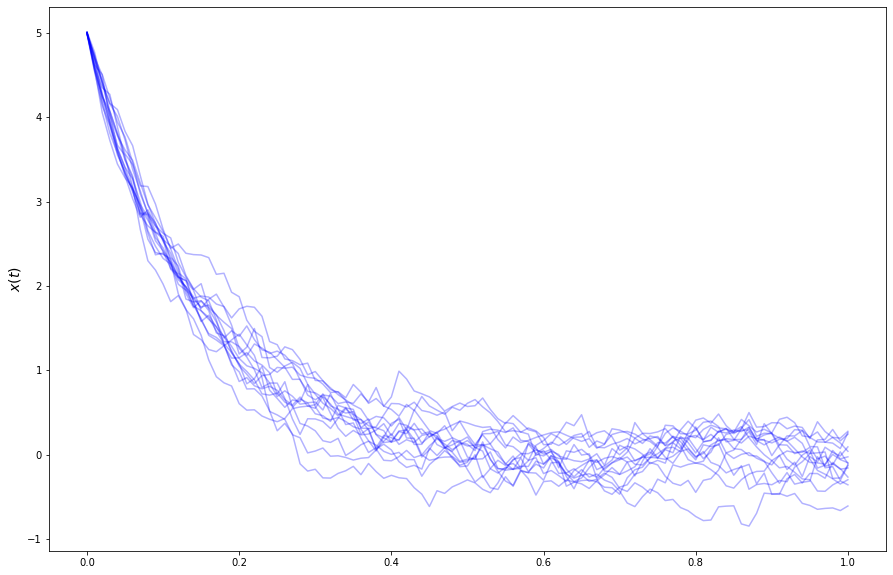

In [249]:
plot_trajectories_2(Xts, t, remove_time=True)

In [251]:
Xts[:,:,0] = Xts[:,:,0].flip(1) ; X_0 = Xts[:,0,0].reshape(-1,1)
Xs, Ys = get_drift_data(Xts, dt, reverse=False)

In [252]:
mattern = gp.kernels.Matern32(input_dim=2)
kernel = gp.kernels.RBF(input_dim=2)
kernel1  = gp.kernels.Periodic(input_dim=2) 
kernel2  = gp.kernels.Linear(input_dim=2)
sum_kernel = gp.kernels.Sum(kernel, mattern)

gp_drift_model  = setup_gp(Xs, Ys.flatten(), dt=dt, kernel=mattern); 

In [253]:
# fit_gp(gp_drift_model, num_steps=100) # Does not seem necesary

In [254]:
gp_ou_drift = lambda x: gp_drift_mean(x, gp_drift_model).reshape(-1, 1)

In [255]:
t_hat, Xts_hat = solve_sde_RK(b_drift=gp_ou_drift,sigma=sigma, X0=X_0, dt=dt, N=N)

<ipython-input-244-0476f31e56a7>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mean).double()


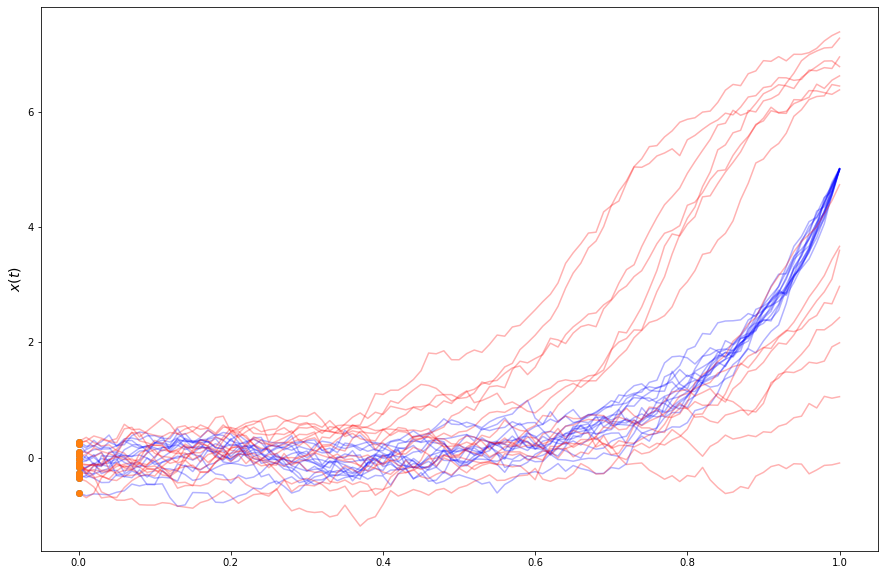

In [256]:
fig_axs = plot_trajectories_2(Xts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hat, t_hat, remove_time=True, fig_axs=fig_axs, color='r');

fig_axs[1].plot([0] * len(Xts_hat[:,0,0]), Xts_hat[:,0,0], 'o')
fig_axs[1].plot([0] * len(X_0), X_0, 'o')

# Fitting Backwards Drift with GP

In this section we reverse the time series before passing it to the GP. Then we inspect that if starting from the empirical hitting distribution of the OU process namely $X_1$ , where does our GP drift take us to, if correct it should take us back to $X_0$ . There seems to be some bug since its far from matching the trajectory, has to be some flag issue.

In [231]:
X_1 = Xts[:,-1,0].reshape(-1,1)

In [232]:
Xsb, Ysb = get_drift_data(Xts, dt, reverse=True)
gp_drift_model_back  = setup_gp(Xsb, Ysb.flatten());
gp_ou_drift_back = lambda x: gp_drift_mean(x, gp_drift_model_back).reshape(-1, 1)

In [238]:
# fit_gp(gp_drift_model_back, num_steps=2500) 

In [175]:
t_hatb, Xts_hatb = solve_sde_RK(b_drift=gp_ou_drift_back,sigma=sigma, X0=X_1, dt=dt, N=N, forwards=False)

<ipython-input-86-e57628f5fa52>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mean).double()


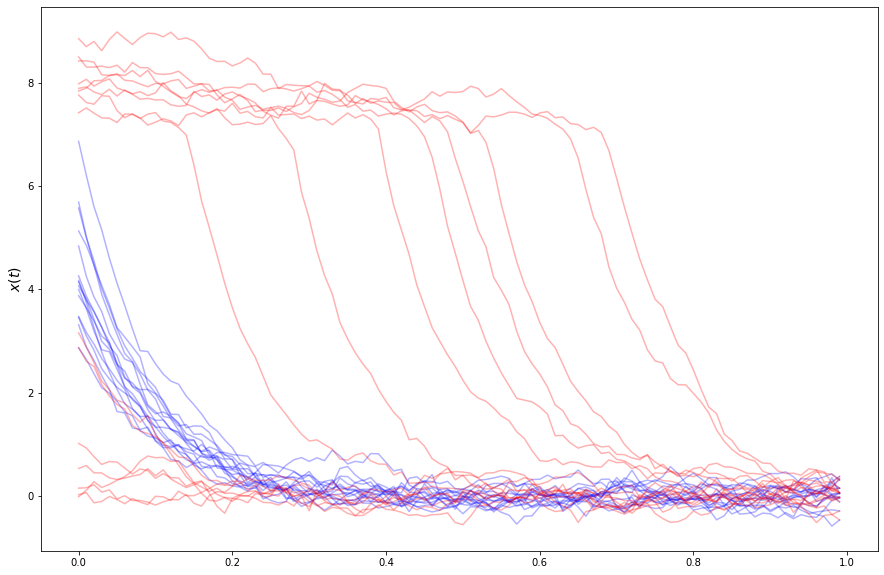

In [176]:
fig_axs = plot_trajectories_2(Xts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hatb, t_hatb.flip(0), remove_time=True, fig_axs=fig_axs, color='r');

# Sanity Check Attempting to show GP can fit the reverse sequence

Rather than switching things on to reverse in this section we just run everything forward but reverse the original input sequence. Looks like for some reason the GP is unable to fit this... which is odd since it should, I showed (empirically) a while back that it could fit similar things.

In [97]:
Xbts = Xts.flip(1)
Xss, Yss = get_drift_data(Xbts, dt, reverse=False)
gp_drift_model_s  = setup_gp(Xss, Yss.flatten(), dt=dt, noise=math.sqrt(dt) *0.1); 
gp_ou_drift_s = lambda x: gp_drift_mean(x, gp_drift_model_s).reshape(-1, 1)

In [98]:
# fit_gp(gp_drift_model_s, num_steps=100) 

In [99]:
t_hat_s, Xts_hat_s = solve_sde_RK(b_drift=gp_ou_drift_s,sigma=sigma, X0=Xbts[:,0,0].reshape(-1,1), dt=dt, N=N)

<ipython-input-7-e57628f5fa52>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mean).double()


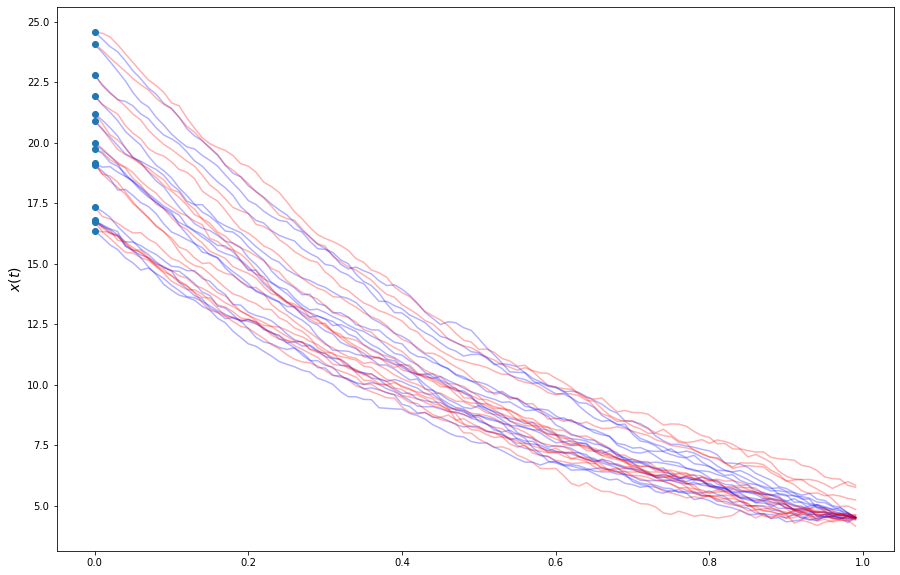

In [100]:


fig_axs = plot_trajectories_2(Xbts, t, remove_time=True, show=False)
plot_trajectories_2(Xts_hat_s, t_hat_s, remove_time=True, fig_axs=fig_axs, color='r');

fig_axs[1].plot([0] * len(Xbts[:,0,0]), Xbts[:,0,0], 'o')

In [32]:
Xbts[:,0,0]

tensor([-0.1575,  0.2547, -0.0523, -0.4487, -0.1506,  0.6938, -0.2114,  0.4039,
        -0.2016,  0.1486, -0.0998,  0.2432,  0.0143, -0.1362, -0.0956],
       dtype=torch.float64)